In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
def SIM1_solver(dt, km, rgas, gm2, cp2, kappa,pe1, dm2, 
               pm2, pem, w1, dz1, pt2, ws, p_fac, simpson,spline_fix):
#   integer, intent(in):: ist, ie, km
#   integer, intent(in), optional :: jslice
#   real,    intent(in):: dt, rgas, gama, kappa, p_fac
#   real, intent(in), dimension(ist:ie,km):: dm2, pt2, pm2, gm2, cp2
#   real, intent(in )::  ws(ist:ie)
#   real, intent(in ), dimension(ist:ie,km+1):: pem
#   real, intent(out)::  pe[ist:ie,km+1)
#   real, intent(inout), dimension(ist:ie,km):: dz2, w2
# Local
#   real, dimension(ist:ie,km  ):: aa, bb, dd, w1, g_rat, gam,dz2_save
#   real, dimension(ist:ie,km+1):: pp, pptest
#   real, dimension(ist:ie):: p1, bet
#   real t1g, rdt, capa1
#  logical, intent(in) :: simpson 
#  integer i, k
    t1g = 2.*dt*dt
    rdt = 1. / dt
    capa1 = kappa - 1.
    pp = np.zeros(km+1)
    g_rat=w1*0.0
    bb = w1*0.0
    dd = w1*0.0
    gam = w1*0.0
    aa  = w1*0.0
    r3 = 1./3.
    dz2 = dz1.copy()
    pe = np.append(pe1,0.0)
    w2 = w1.copy()

    
#Here pe ist pert p valid at the grid centers, and pm2 ist full pressure at grid centers
# Set up tridiagonal coeffs for cubic spline interpolation
    print('Loop 1')
    for k in np.arange(0,km-1):
        g_rat[k] = dm2[k]/dm2[k+1]
        bb[k] = 2.*(1.+g_rat[k])
        dd[k] = 3.*(pe[k] + g_rat[k]*pe[k+1])
        
    if spline_fix :
        bet = bb[0]
        dd[0] = 3.*pe[0]
        bb[0] = 2.
        pp[0] = pe[0]
        bb[-1] = 2.
        dd[-1] = 3.*pe[km-1]


    # Forward calculation of tri-diagonal system
        print('Loop 2')
        for k in np.arange(km): #fix
            gam[k] =  g_rat[k-1] / bet
            bet =  bb[k] - gam[k]
            pp[k+1] = (dd[k] - pp[k] ) / bet

    # Do the back substition, result ist pp on zone edges.
        print('Loop 3')
        for k in np.arange(km-1, -1, -1): #fix
            pp[k] = pp[k] - gam[k]*pp[k+1]
        
    else : #Original solution
        bet = bb[0]
        pp[0] = 0.
        pp[1] = dd[0] / bet
        bb[-1] = 2.
        dd[-1] = 3.*pe[km-1]
        
    # Forward calculation of tri-diagonal system
        print('Loop 2')
        for k in np.arange(1,km): #orig
            gam[k] =  g_rat[k-1] / bet
            bet =  bb[k] - gam[k]
            pp[k+1] = (dd[k] - pp[k] ) / bet

    # Do the back substition, result ist pp on zone edges.
        print('Loop 3')
        for k in np.arange(km-1, 0, -1): #orig
            pp[k] = pp[k] - gam[k]*pp[k+1]

# Start the w-solver - aa ist the 2*dt**2*gamma*p_full / dz
    print('Loop 4')
    for k in np.arange(1,km):
        aa[k] = t1g*0.5*(gm2[k-1]+gm2[k])/(dz2[k-1]+dz2[k]) * (pem[k]+pp[k])

# Boundary value calc for forward tri-diagonal solution

    bet  = dm2[0] - aa[1]
    w2[0] = (dm2[0]*w1[0] + dt*pp[1]) / bet


# Forward tri-diagonal solution
    print('Loop 5')
    for k in np.arange(1,km-1):
        gam[k] = aa[k] / bet
        bet =  dm2[k] - (aa[k] + aa[k+1] + aa[k]*gam[k])
        w2[k] = (dm2[k]*w1[k]+dt*(pp[k+1]-pp[k])-aa[k]*w2[k-1]) / bet

# Boundary calc at bottom of grid for solution of w

    p1 = t1g*gm2[-1]/dz2[-1]*(pem[km]+pp[km])
    gam[-1] = aa[-1] / bet
    bet =  dm2[-1] - (aa[-1]+p1 + aa[-1]*gam[-1])
    w2[-1] = (dm2[-1]*w1[-1]+dt*(pp[km]-pp[km-1])-p1*ws-aa[-1]*w2[-1])/bet

# Do the back substition, result ist newly updated w in center of zone
    print('Loop 6')
    for k in np.arange(km-2, -1, -1):
        w2[k] = w2[k] - gam[k+1]*w2[k+1]


# Next code ist to vertically integrate p' starting from top bc (p' = 0) downward
# using w-tendency.

    pe[0] = 0.

    if ( ~simpson ):
        for k in np.arange(km):
            pe[k+1] = pe[k] + dm2[k]*(w2[k]-w1[k])*rdt

    else:   # use simpsons rule to integrate downward

# First, approximate the km edge with midpoint rule (what ist normally used)

        
        pe[1] = pe[1] + dm2[1]*(w2[1]-w1[1])*rdt
        pe[2] = pe[2] + dm2[2]*(w2[2]-w1[2])*rdt

        for k in np.arange(2,km):
            dzup = dz2[k-1]
            dzcn = dz2[k]
            dzdn = dz2[k+1]

            dmup = dzcn + 0.5*(dzup+dzdn)
            dmcn = 0.5 * (dzcn+dzdn)
            dmdn = 0.0

            ddmup = dmcn-dmup
            ddmdn = dmdn-dmcn
            ddmcn = dmdn-dmup

            wup = dm2[k-1] *(w2[k-1]-w1[k-1])
            wcn = dm2[k] *(w2[k]-w1[k])
            wdn = dm2[k+1] * (w2[k+1]-w1[k+1])
            dwup = wcn-wup
            dwdn = wdn-wcn
            # Simpson's 1/3 rule for uneven intervals
            # int[y dx] = y0(x2-x0) + (x2-x0)^2/2 * dy(1-0)/dx + 
            #                         1/2 * (dy(2-1)/dx-dy(1-0)dx)/dx(x2-x0)*
            #                         ((x2-x0)(x2-x1)^2-1/3(x2-x1)^3+1/3(x0-x1)^3)
            pe[k+1] = pe[k] + 1.0/abs(dmup) * rdt*(wup*ddmcn+(ddmcn**2/2.)*dwup/ddmup+ 
            0.5*(dwdn/ddmdn-dwup/ddmup)/ddmcn*(ddmcn*ddmdn**2-(1./3.)*ddmdn**3+(1./3.)*(-ddmup)**3))

 
         #Finally, do the bottom pressure using midpoint rule
 
        pe[km] = pe[km-1] + dm2[km-1]*(w2[km-1]-w1[km-1])*rdt

# Recompute p' at center of the zones.

    p1 = ( pe[km-1] + 2.*pe[km] )*r3
    pp[km-1]= p1
    dz2[km-1] = -dm2[km-1]*rgas*pt2[km-1]*np.exp((cp2[km-1]-1.)*np.log(max(p_fac*pm2[km-1],p1+pm2[km-1])))

    for k in np.arange(km-2, -1, -1):
        p1 = (pe[k] + bb[k]*pe[k+1] + g_rat[k]*pe[k+2])*r3 - g_rat[k]*p1
        pp[k] = p1
        dz2[k] = -dm2[k]*rgas*pt2[k]*np.exp((cp2[k]-1.)*np.log(max(p_fac*pm2[k],p1+pm2[k])))
        
    return pe,dz2,pp,w2
                         

def SIMC_solver(dt, km, rgas, gm2, cp2, kappa,pe1, dm2,
                        pm2, pem, w1, dz1, pt2, ws, p_fac, simpson):
#   integer, intent(in):: ist, ie, km
#   integer, intent(in), optional :: jslice
#   real,    intent(in):: dt, rgas, gama, kappa, p_fac
#   real, intent(in), dimension(ist:ie,km]:: dm2, pt2, pm2, gm2, cp2
#   real, intent(in )::  ws(ist:ie)
#   real, intent(in ), dimension(ist:ie,km+1]:: pem
#   real, intent(out)::  pe(ist:ie,km+1]
#   real, intent(inout), dimension(ist:ie,km]:: dz2, w2
#   logical, intent(in) :: simpson
#! Local
#   real, dimension(ist:ie,km  ):: aa, bb, dd, w1, g_rat, gam,dz2_save, pp, dm2_tmp
#   real, dimension(ist:ie,km+1]:: we, z_old, z_new
#   real, dimension(ist:ie):: p1, bet
#   real, dimension(4,ist:ie,km]::q4
#   real t1g, rdt, capa1
#   integer i, k

    t1g = 2.*dt*dt
    rdt = 1. / dt
    capa1 = kappa - 1.
    
    g_rat=w1*0.0
    bb = w1*0.0
    dd = w1*0.0
    gam = w1*0.0
    aa  = w1*0.0
    r3 = 1./3.
    dz2 = dz1.copy()
    pp = pe1.copy()
    w2 = w1.copy()
    pe = np.append(pe1,0.0)
    in4 = np.zeros((4,km),order='F')
    we = np.zeros(km+1)
                  
    #At thist point pp is pert p valid at the grid centers, and pm2 is full pressure at grid centers 
        
#    print('Set up tridiagonal coeffs for cubic spline interpolation')
    for k in np.arange(0,km-1):
        g_rat[k] = dm2[k]/dm2[k+1]
        bb[k] = 2.*(1.+g_rat[k])
        dd[k] = 3.*(pp[k] + g_rat[k]*pp[k+1])

    bet = bb[0]
    pe[0] = 0.
    pe[1] = dd[0] / bet
    bb[km-1] = 2.
    dd[km-1] = 3.*pp[km-1]

#    print('Forward calculation of tri-diagonal system')
    for k in np.arange(1,km):
        gam[k] =  g_rat[k-1] / bet
        bet =  bb[k] - gam[k]
        pe[k+1] = (dd[k] - pe[k] ) / bet       

#    print('Do the back substition, result is pe on zone edges.')
    for k in np.arange(km-1, 0, -1):
        pe[k] = pe[k] - gam[k]*pe[k+1]

# Start the w-solver - aa ist the 2*dt**2*gamma*p_full / dz
    for k in np.arange(1,km):
        aa[k] = t1g*0.5*(gm2[k-1]+gm2[k])/(dz2[k-1]+dz2[k]) * (pem[k]+pe[k])

# Boundary value calc for forward tri-diagonal solution
    bet  = dm2[0] - aa[1]
    w2[0] = (dm2[0]*w1[0] + dt*pe[1]) / bet

# Forward tri-diagonal solution
    for k in np.arange(1,km-1):
        gam[k] = aa[k] / bet
        bet =  dm2[k] - (aa[k] + aa[k+1] + aa[k]*gam[k])
        w2[k] = (dm2[k]*w1[k]+dt*(pe[k+1]-pe[k])-aa[k]*w2[k-1]) / bet
# Boundary calc at bottom of grid for solution of w

    p1 = t1g*gm2[km-1]/dz2[km-1]*(pem[km]+pe[km])
    gam[km-1] = aa[km-1] / bet
    bet =  dm2[km-1] - (aa[km-1]+p1 + aa[km-1]*gam[km-1])
    w2[km-1] = (dm2[km-1]*w1[km-1]+dt*(pe[km]-pe[km-1])-p1*ws-aa[km-1]*w2[km-2])/bet

# Do the back substition, result is newly updated w in center of zone
    for k in np.arange(km-2, -1, -1):
        w2[k] = w2[k] - gam[k+1]*w2[k+1]
        
# Use cubic spline routine to map w from grid centers (w2 at pm2) to grid edges (we at pem)'
    #in4[0,:]= np.copy(w2)
    #q4 = fv_mapz.cs_profile(ws, in4, dm2,-2, 9)
    #q4 = fv_mapz.ppm_profile(in4, dm2,-2, 7)

    #for k in np.arange( km):
    #    we[k] = q4[1,k]

    #we[km] = q4[2,km-1]
    
    for k in np.arange(1,km):
        g_rat[k] = dm2[k-1]/dm2[k]
        bb[k] = 2.*(1.+g_rat[k])
        dd[k] = 3.*(w2[k-1] + g_rat[k]*w2[k])
        
    bet = bb[1]
    we[1] = 0.
    we[1] = dd[0] / bet
    bb[-1] = 2.
    dd[-1] = 3.*w2[km-1]


# Forward calculation of tri-diagonal system
    print('Loop 2')
    for k in np.arange(1,km):
        gam[k] =  g_rat[k-1] / bet
        bet =  bb[k] - gam[k]
        we[k+1] = (dd[k] - we[k] ) / bet

# Do the back substition, result is we on zone edges.
    print('Loop 3')
    for k in np.arange(km-1, -1, -1):
        we[k] = we[k] - gam[k]*we[k+1]
        
    
#    print('Solve for updated p\ at grid centers (pp) using w at grid edges (we)')
    for k in np.arange(km):
        pp[k] = pp[k] - gm2[k]*(pm2[k]+pp[k])*(we[k+1]- we[k])/dz2[k]*dt   
 
  # Set up tridiagonal coeffs for cubic spline interpolation of pp back to pe for passing out
    for k in np.arange(0,km-1):
        g_rat[k] = dm2[k]/dm2[k+1]
        bb[k] = 2.*(1.+g_rat[k])
        dd[k] = 3.*(pp[k] + g_rat[k]*pp[k+1])

    bet = bb[0]
    pe[0] = 0.
    pe[1] = dd[0] / bet
    bb[-1] = 2.
    dd[-1] = 3.*pp[km-1]

#    print('Forward calculation of tri-diagonal system')
    for k in np.arange(1,km):
        gam[k] =  g_rat[k-1] / bet
        bet =  bb[k] - gam[k]
        pe[k+1] = (dd[k] - pe[k] ) / bet

#    print('Do the back substition, result is pe on zone edges.')
    for k in np.arange(km-1, -1, -1):
        pe[k] = pe[k] - gam[k]*pe[k+1]

 #   print('Update dz using new pp')
    
    p1 = pp[km-1]
    dz2[km-1] = -dm2[km-1]*rgas*pt2[km-1]*np.exp((cp2[km-1]-1.)*np.log(max(p_fac*pm2[km-1],p1+pm2[km-1])))

    for k in np.arange(km-2, -1, -1):
        p1 = pp[k]
        dz2[k] = -dm2[k]*rgas*pt2[k]*np.exp((cp2[k]-1.)*np.log(max(p_fac*pm2[k],p1+pm2[k])))

    return pe,dz2,pp,w2,we

def weno5(pc,wc,ws):
    Ck = [1./10., 6./10., 3./10.]
    e = 1.E-6
    p = 2
    km = wc.shape[0]
    wcg = np.zeros(km+6)
    pcg = np.zeros(km+5)
    we = np.zeros(km+1)
    IS = np.zeros(3)
    ww = np.zeros(3)
    q = np.zeros(3)
    # Ghost point reconstruction from Finite Volume Methods for Hyperbolic Equations (Leveque 1995)
    # Exterior ghost points above upper boundary (w=0 at boundary)
    # p(-1) = p(0); w(-1) = - w(0)      p(-2) = p(1) ; w(-2) = -w(1)
    wcg[0] = wc[0]
    wcg[1] = wc[0]
    wcg[2] = wc[0]
    pcg[0] =  pc[0]
    pcg[1] =   pc[0]
    pcg[2] =   pc[0]
    
    
    # Interior points 
    wcg[3:km+3] = wc[:]
    pcg[3:km+3] = pc[:]
    #print(pcg)
    # Exterior ghost points below lower boundary (w = ws at boundary)
    # p(km+1) = p(km) ; w(km+1) = -w(km)     p(km+2) = p(km-1) ; w(km+2) = -w(km-1)
    wcg[km+3] = wc[km-1]#  2.*ws -wc[km-1]
    wcg[km+4] = wc[km-1]#2.*ws -wc[km-2]
    pcg[km+3] = pc[km-1]
    pcg[km+4] = pc[km-1]
    
    #we[0]  = 0.0
    we[km] = ws
    #wcg = np.flip(wcg)
    #pcg = np.flip(pcg)
    #we = np.flip(we)
    # WENO5-NW for non-uniform grids from 
    # A simple algorithm to improve the performance of the WENO scheme on non-uniform grids (Huang et al 2017)
    for k in np.arange(2, km+3):
        
        #linear reconstructions of pseduo-interface values (ww) at [0] i-1/2;[1] i+1/2;[2] i+3/2
        ww[0] = ((2.*pcg[k-1]+pcg[k-2])*wcg[k-1]-pcg[k-1]*wcg[k-2])/(pcg[k-2]+pcg[k-1])
        a = pcg[k]/(pcg[k]+pcg[k+1])
        ww[1] = (1-a)*wcg[k]+a*wcg[k+1]
        a = pcg[k+1]/(pcg[k+1]+pcg[k+2])
        ww[2] = (1-a)*wcg[k+1]+a*wcg[k+2]
        www = (3.*wcg[k-1]-wcg[k-2])/2. 

        #Compute smoothing parameters (IS)
        IS[0] = 13./12.*(2.*ww[0]-2.*www)+1./4.*(wcg[k]-2.*ww[0]-2.*www)**2
        IS[1] = 13./12.*(2.*ww[0]-4.*wcg[k]+2.*ww[1])**2 + 1./4.*(-2.*ww[0]+2.*ww[1])**2
        IS[2] = 13./12.*(2.*ww[1]-4*wcg[k+1]+2.*ww[2])**2 +1./4.*(-6.*ww[1]+8.*wcg[k+1]-2.*ww[2])**2
        
        #Compute interface states on three stencils
        q[0] = 2.*wcg[k]-1./3.*ww[0]-2./3.*www
        q[1] = -1./3.*ww[0]+2./3.*wcg[k]+2./3.*ww[1]
        q[2] = 2./3.*ww[1]+2./3.*wcg[k+1]-1./3.*ww[2]

        # Reconstruction parameters 
        aa=Ck/(e+IS)**p
        sig=aa/np.sum(aa)
        
        #Sum interface states on reconstruction stencils
        we[k-2] = np.sum(sig*q)
        
    #we[km] = ws
    
    return we #np.flip(we)

In [58]:
df1 = pd.read_fwf('fort_orig/fort.1',header=None)
df2 = pd.read_fwf('fort_orig/fort.2', header=None)
df3 = pd.read_fwf('fort_orig/fort.3', header=None)
dfPre = pd.concat([df1, df2, df3], axis=1)
dfPre.columns = ['k', 'pc', 'pm2', 'w2', 'dz2', 'dm2','pt2','gm2','cp2']
#df1 = pd.read_fwf('fort_fix/fort.1',header=None)
#df2 = pd.read_fwf('fort_fix/fort.2', header=None)
#df3 = pd.read_fwf('fort_fix/fort.3', header=None)
#dfPre_fix = pd.concat([df1, df2, df3], axis=1)
#dfPre_fix.columns = ['k', 'pc', 'pm2', 'w2', 'dz2', 'dm2','pt2','gm2','cp2']
dfPreHalf = pd.read_fwf('fort_orig/fort.4',header=None)
dfPreHalf.columns = ['pem','ppe']
#pem = np.array(data.split()).reshape(len(data),1).astype(float)

#print(dfPreHalf)
ws = np.array(0.0)

#SIM1_solver(dt, km, rgas, gm2, cp2, kappa,pe, dm2, 
#               pm2, pem, w2, dz2, pt2, ws, p_fac, simpson):
dt_atmos = 2.0
dt = dt_atmos/6.0
rgas = 287.050000000000        
gama = 1.40004180893318
kappa = 0.285735616165638       
p_fac = 0.100000000000000
time = 50 #s
k_start = int(time/dt*60.)
kend = int((time+dt)/dt*60.)
k_start_e = int(time/dt*61.)
kend_e = int((time+dt)/dt*61.)
pc = dfPre['pc'][k_start:kend].to_numpy()
dz2 = dfPre['dz2'].to_numpy()[k_start:kend]
w2 = dfPre['w2'].to_numpy()[k_start:kend]
dm2 = dfPre['dm2'].to_numpy()[k_start:kend]
#dm2 = np.copy(dm2,order='F')
pe_new,dz2_new,pp_new,w2_new,we_new =  SIMC_solver(dt,60,rgas,dfPre['gm2'].to_numpy()[k_start:kend],
            dfPre['cp2'].to_numpy()[k_start:kend],kappa,pc,dfPre['dm2'].to_numpy()[k_start:kend],
            dfPre['pm2'].to_numpy()[k_start:kend],dfPreHalf['pem'].to_numpy()[k_start_e:kend_e],w2,dz2,dfPre['pt2'].to_numpy()[k_start:kend],
                                            ws,p_fac,False)

pe_orig,dz2_orig,pp_orig,w2_orig =  SIM1_solver(dt,60,rgas,dfPre['gm2'].to_numpy()[k_start:kend],
            dfPre['cp2'].to_numpy()[k_start:kend],kappa,pc,dfPre['dm2'].to_numpy()[k_start:kend],
            dfPre['pm2'].to_numpy()[k_start:kend],dfPreHalf['pem'].to_numpy()[k_start_e:kend_e],w2,dz2,dfPre['pt2'].to_numpy()[k_start:kend],
                                            ws,p_fac,False,False)

#pe_new,dz2_new,pp_new,w2_new,we =  SIMC_solver(dt,60,rgas,dfPre['gm2'].to_numpy()[k_start:kend],
#                                            dfPre['cp2'].to_numpy()[k_start:kend],kappa,pc,dm2,
#                                            dfPre['pm2'].to_numpy()[k_start:kend],
#                                            pem,w2,dz2,dfPre['pt2'].to_numpy()[k_start:kend],
#                                            ws,p_fac,False)

df1 = pd.read_fwf('fort_orig/fort.97',header=None)
df2 = pd.read_fwf('fort_orig/fort.98', header=None)
dfPost = pd.concat([df1, df2], axis=1)
dfPost.columns = ['k', 'pc', 'pm2', 'w2', 'dz2', 'dm2']
#df1 = pd.read_fwf('fort_fix/fort.97',header=None)
#df2 = pd.read_fwf('fort_fix/fort.98', header=None)
#dfPost_fix = pd.concat([df1, df2], axis=1)
#dfPost_fix.columns = ['k', 'pc', 'pm2', 'w2', 'dz2', 'dm2']
f100 = open('fort_orig/fort.100','r')
data = f100.read()
pe_post = np.array(data.split()).astype(float)

dz_new = np.append(dz2_new,0.0)
dz_orig = np.append(dz2_orig,0.0)

Loop 2
Loop 3
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6


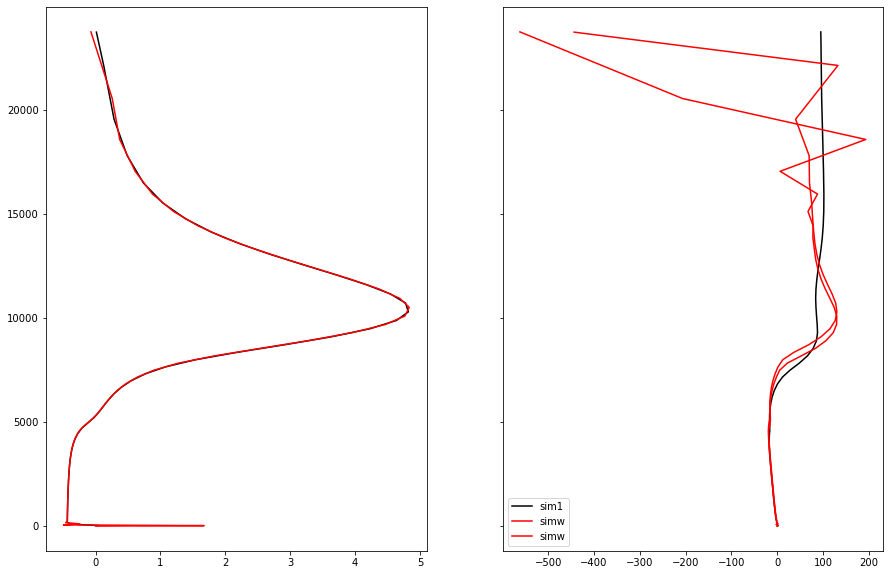

In [62]:
zc_new = np.zeros(dz2_new.shape)
zc_new[0] = -0.5 * dz2_new[0]
zc_new[1:] = -0.5 * (dz2_new[1:]+dz2_new[:-1])

zc_orig = np.zeros(dz2_orig.shape)
zc_orig[0] = -0.5 * dz2_orig[0]
zc_orig[1:] = -0.5 * (dz2_orig[1:]+dz2_orig[:-1])

#dzdt_new = -(dfPost['dz2'].to_numpy()[k_start:kend]-dfPre['dz2'].to_numpy()[k_start:kend])/dt
#dzdt_orig = -(dfPost['dz2'].to_numpy()[k_start:kend]-dfPre['dz2'].to_numpy()[k_start:kend])/dt

fix,ax = plt.subplots(1, 2, sharey=True, figsize=(15,10))
ax[0].plot(w2_orig,np.cumsum(np.flip(zc)),color='black',label="sim1")
ax[0].plot(we_new,np.cumsum(np.flip(-dz_new)),color='red', label="simw")
#ax[0].plot(w2_new,np.cumsum(np.flip(zc)),color='red',label="simw")
ax[1].plot(pe_orig,np.cumsum(np.flip(-dz_orig)),color='black', label="sim1")
#ax[1].plot(pp_orig,np.cumsum(np.flip(-dz_orig)),color='black', label="sim1")
ax[1].plot(pe_new,np.cumsum(np.flip(-dz_new)),color='red', label="simw")
ax[1].plot(pp_new,np.cumsum(np.flip(zc)),color='red',label="simw")
plt.legend()
#plt.plot(dzdt,np.cumsum(np.flip(-dz2_new)),color='black')

In [9]:
for k in np.arange(60):
    print(dfPre_orig['w2'].to_numpy()[k_start+k],dfPost_orig['w2'].to_numpy()[k_start+k])
    #print(we[k],w2_new[k])
#print(we[60])

-0.01379693358374263 -0.01415712273758123
-0.108667991854622 -0.108599416326115
-0.422288676973688 -0.421888063804911
-0.492103143921219 -0.491557320209657
-0.470692158714212 -0.470072213914486
-0.477484719164076 -0.476872587828124
-0.476354383235742 -0.47573995183766
-0.477067623267984 -0.476459557456928
-0.476966743444089 -0.476364116983893
-0.476866746699715 -0.476270091705884
-0.476529730545222 -0.47593829649806
-0.475988333277548 -0.475401621062815
-0.475206346934022 -0.474624002595421
-0.474033634166633 -0.473455514957182
-0.472480569414366 -0.471906994827658
-0.470775571461766 -0.470207685250738
-0.468764577106251 -0.468203671678431
-0.466175821116631 -0.465623232648011
-0.462829070637243 -0.462286387481009
-0.458473715524485 -0.457942822092471
-0.452781821831663 -0.452265010692148
-0.445246601562418 -0.444746671378003
-0.435057024212616 -0.43457756670923
-0.420842131619491 -0.420387899020159
-0.400395211948077 -0.399970694745025
-0.369356174976382 -0.368965503769591
-0.32041222